In [15]:
# ─────────────────────────────────────────────────────────────
# Import Required Libraries
# ─────────────────────────────────────────────────────────────
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (20, 16)
plt.rcParams['font.size'] = 12

In [16]:
# ─────────────────────────────────────────────────────────────
# Load and Prepare Data
# ─────────────────────────────────────────────────────────────

# Load the preprocessed dataset
data_path = r"d:\GitHub Repos\spray-vision\data\processed\preprocessed_dataset.csv"
raw = pd.read_csv(data_path)

# Harmonize column names to match those used during model training
rename_map = {
    "Time_ms"        : "time",
    "Pc_bar"         : "chamb_pressure", 
    "Tc_K"           : "cham_temp",
    "Pinj_bar"       : "injection_pres",
    "rho_kgm3"       : "density",
    "mu_Pas"         : "viscosity",
    "angle_shadow_deg": "angle_shadow",
    "len_shadow_L_D" : "length_shadow", 
    "angle_mie_deg"  : "angle_mie",
    "len_mie_L_D"    : "length_mie",
}
df = raw.rename(columns=rename_map)

# Display basic info about the dataset
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

# Define features and targets exactly as used in training
INPUTS  = ["time", "chamb_pressure", "cham_temp", "injection_pres", "density", "viscosity"]
TARGETS = ["angle_mie", "length_mie", "angle_shadow", "length_shadow"]

print(f"\nFeature columns ({len(INPUTS)}):", INPUTS)
print(f"Target columns ({len(TARGETS)}):", TARGETS)

Dataset shape: (726, 11)

Columns: ['run', 'time', 'chamb_pressure', 'cham_temp', 'injection_pres', 'density', 'viscosity', 'angle_shadow', 'length_shadow', 'angle_mie', 'length_mie']

First few rows:
      run   time  chamb_pressure   cham_temp  injection_pres     density  \
0  ETH-01  0.000        55.03180  192.029519       98.864550  810.720228   
1  ETH-01  0.025        55.00570  192.015831       98.874062  810.718262   
2  ETH-01  0.050        55.00810  191.988228       98.907356  810.718443   
3  ETH-01  0.075        55.01635  192.081988       98.855037  810.719065   
4  ETH-01  0.100        55.01250  191.988000       98.878819  810.718775   

   viscosity  angle_shadow  length_shadow  angle_mie  length_mie  
0   0.001879     16.694545      13.126559  12.937325   17.571262  
1   0.001879     16.694545      13.126559  12.937325   17.571262  
2   0.001879     16.694545      13.126559  12.937325   17.571262  
3   0.001879     16.694545      13.126559  12.937325   17.571262  
4   0.0

In [17]:
# ─────────────────────────────────────────────────────────────
# Prepare Training Data and Split
# ─────────────────────────────────────────────────────────────

from sklearn.model_selection import train_test_split

# Prepare features and targets using the same names as training
X = df[INPUTS]
y = df[TARGETS]
runs = df["run"]  # for stratification

# Split the data using the same parameters as training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=runs
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

# Scale the data for models that need it
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler() 
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

Training set shape: (580, 6) (580, 4)
Test set shape: (146, 6) (146, 4)


In [18]:
# ─────────────────────────────────────────────────────────────
# Load Pre-trained Models and Generate Predictions
# ─────────────────────────────────────────────────────────────

# Define model paths
models_dir = r"d:\GitHub Repos\spray-vision\models"

# Define the 6 baseline ML models
baseline_models = {
    'Linear Regression': 'LinearRegression_regressor.joblib',
    'Decision Tree': 'DecisionTree_regressor.joblib', 
    'Random Forest': 'RandomForest_regressor.joblib',
    'Gradient Boosting': 'GradientBoosting_regressor.joblib',
    'SVR': 'SVR_regressor.joblib',
    'KNN': 'KNN_regressor.joblib'
}

# Store predictions for all models
predictions = {}

# Load and predict with baseline ML models
print("Loading baseline ML models and generating predictions...")
for model_name, model_file in baseline_models.items():
    try:
        model_path = os.path.join(models_dir, model_file)
        model = joblib.load(model_path)
        
        # Generate predictions on test set
        y_pred = model.predict(X_test)
        predictions[model_name] = y_pred
        
        print(f"✓ {model_name}: Predictions generated")
        
    except Exception as e:
        print(f"✗ Error loading {model_name}: {e}")

print(f"\nLoaded {len(predictions)} baseline models successfully")

Loading baseline ML models and generating predictions...
✓ Linear Regression: Predictions generated
✓ Decision Tree: Predictions generated
✓ Random Forest: Predictions generated
✓ Gradient Boosting: Predictions generated
✓ SVR: Predictions generated
✓ KNN: Predictions generated

Loaded 6 baseline models successfully
✓ Random Forest: Predictions generated
✓ Gradient Boosting: Predictions generated
✓ SVR: Predictions generated
✓ KNN: Predictions generated

Loaded 6 baseline models successfully


In [19]:
# ─────────────────────────────────────────────────────────────
# Load ANN Model and Generate Predictions
# ─────────────────────────────────────────────────────────────

# Load ANN model and scalers
print("Loading ANN model...")
try:
    # Try to load the original ANN model first
    ann_model = keras.models.load_model(os.path.join(models_dir, 'ANN_regressor.h5'))
    
    # Load the scalers used for ANN
    ann_input_scaler = joblib.load(os.path.join(models_dir, 'ann_input_scaler.joblib'))
    ann_target_scaler = joblib.load(os.path.join(models_dir, 'ann_target_scaler.joblib'))
    
    # Scale the test input data
    X_test_ann_scaled = ann_input_scaler.transform(X_test)
    
    # Generate predictions
    y_pred_ann_scaled = ann_model.predict(X_test_ann_scaled, verbose=0)
    
    # Inverse transform to original scale
    y_pred_ann = ann_target_scaler.inverse_transform(y_pred_ann_scaled)
    
    # Store ANN predictions
    predictions['ANN'] = y_pred_ann
    
    print("✓ ANN: Predictions generated")
    
except Exception as e:
    print(f"✗ Error loading ANN model: {e}")
    # Try loading the improved version
    try:
        print("Trying improved ANN model...")
        ann_model = keras.models.load_model(os.path.join(models_dir, 'ANN_improved_regressor.h5'))
        
        # Load the scalers used for ANN
        ann_input_scaler = joblib.load(os.path.join(models_dir, 'ann_input_scaler.joblib'))
        ann_target_scaler = joblib.load(os.path.join(models_dir, 'ann_target_scaler.joblib'))
        
        # Scale the test input data
        X_test_ann_scaled = ann_input_scaler.transform(X_test)
        
        # Generate predictions
        y_pred_ann_scaled = ann_model.predict(X_test_ann_scaled, verbose=0)
        
        # Inverse transform to original scale
        y_pred_ann = ann_target_scaler.inverse_transform(y_pred_ann_scaled)
        
        # Store ANN predictions
        predictions['ANN (Improved)'] = y_pred_ann
        
        print("✓ ANN (Improved): Predictions generated")
        
    except Exception as e2:
        print(f"✗ Error loading improved ANN model: {e2}")

print(f"\nTotal loaded models: {len(predictions)}")
print("Available models:", list(predictions.keys()))

Loading ANN model...
✗ Error loading ANN model: Could not deserialize 'keras.metrics.mse' because it is not a KerasSaveable subclass
Trying improved ANN model...
✗ Error loading improved ANN model: Could not deserialize 'keras.metrics.mse' because it is not a KerasSaveable subclass

Total loaded models: 6
Available models: ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'SVR', 'KNN']
✗ Error loading improved ANN model: Could not deserialize 'keras.metrics.mse' because it is not a KerasSaveable subclass

Total loaded models: 6
Available models: ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'SVR', 'KNN']


Creating comprehensive true vs predicted plot...


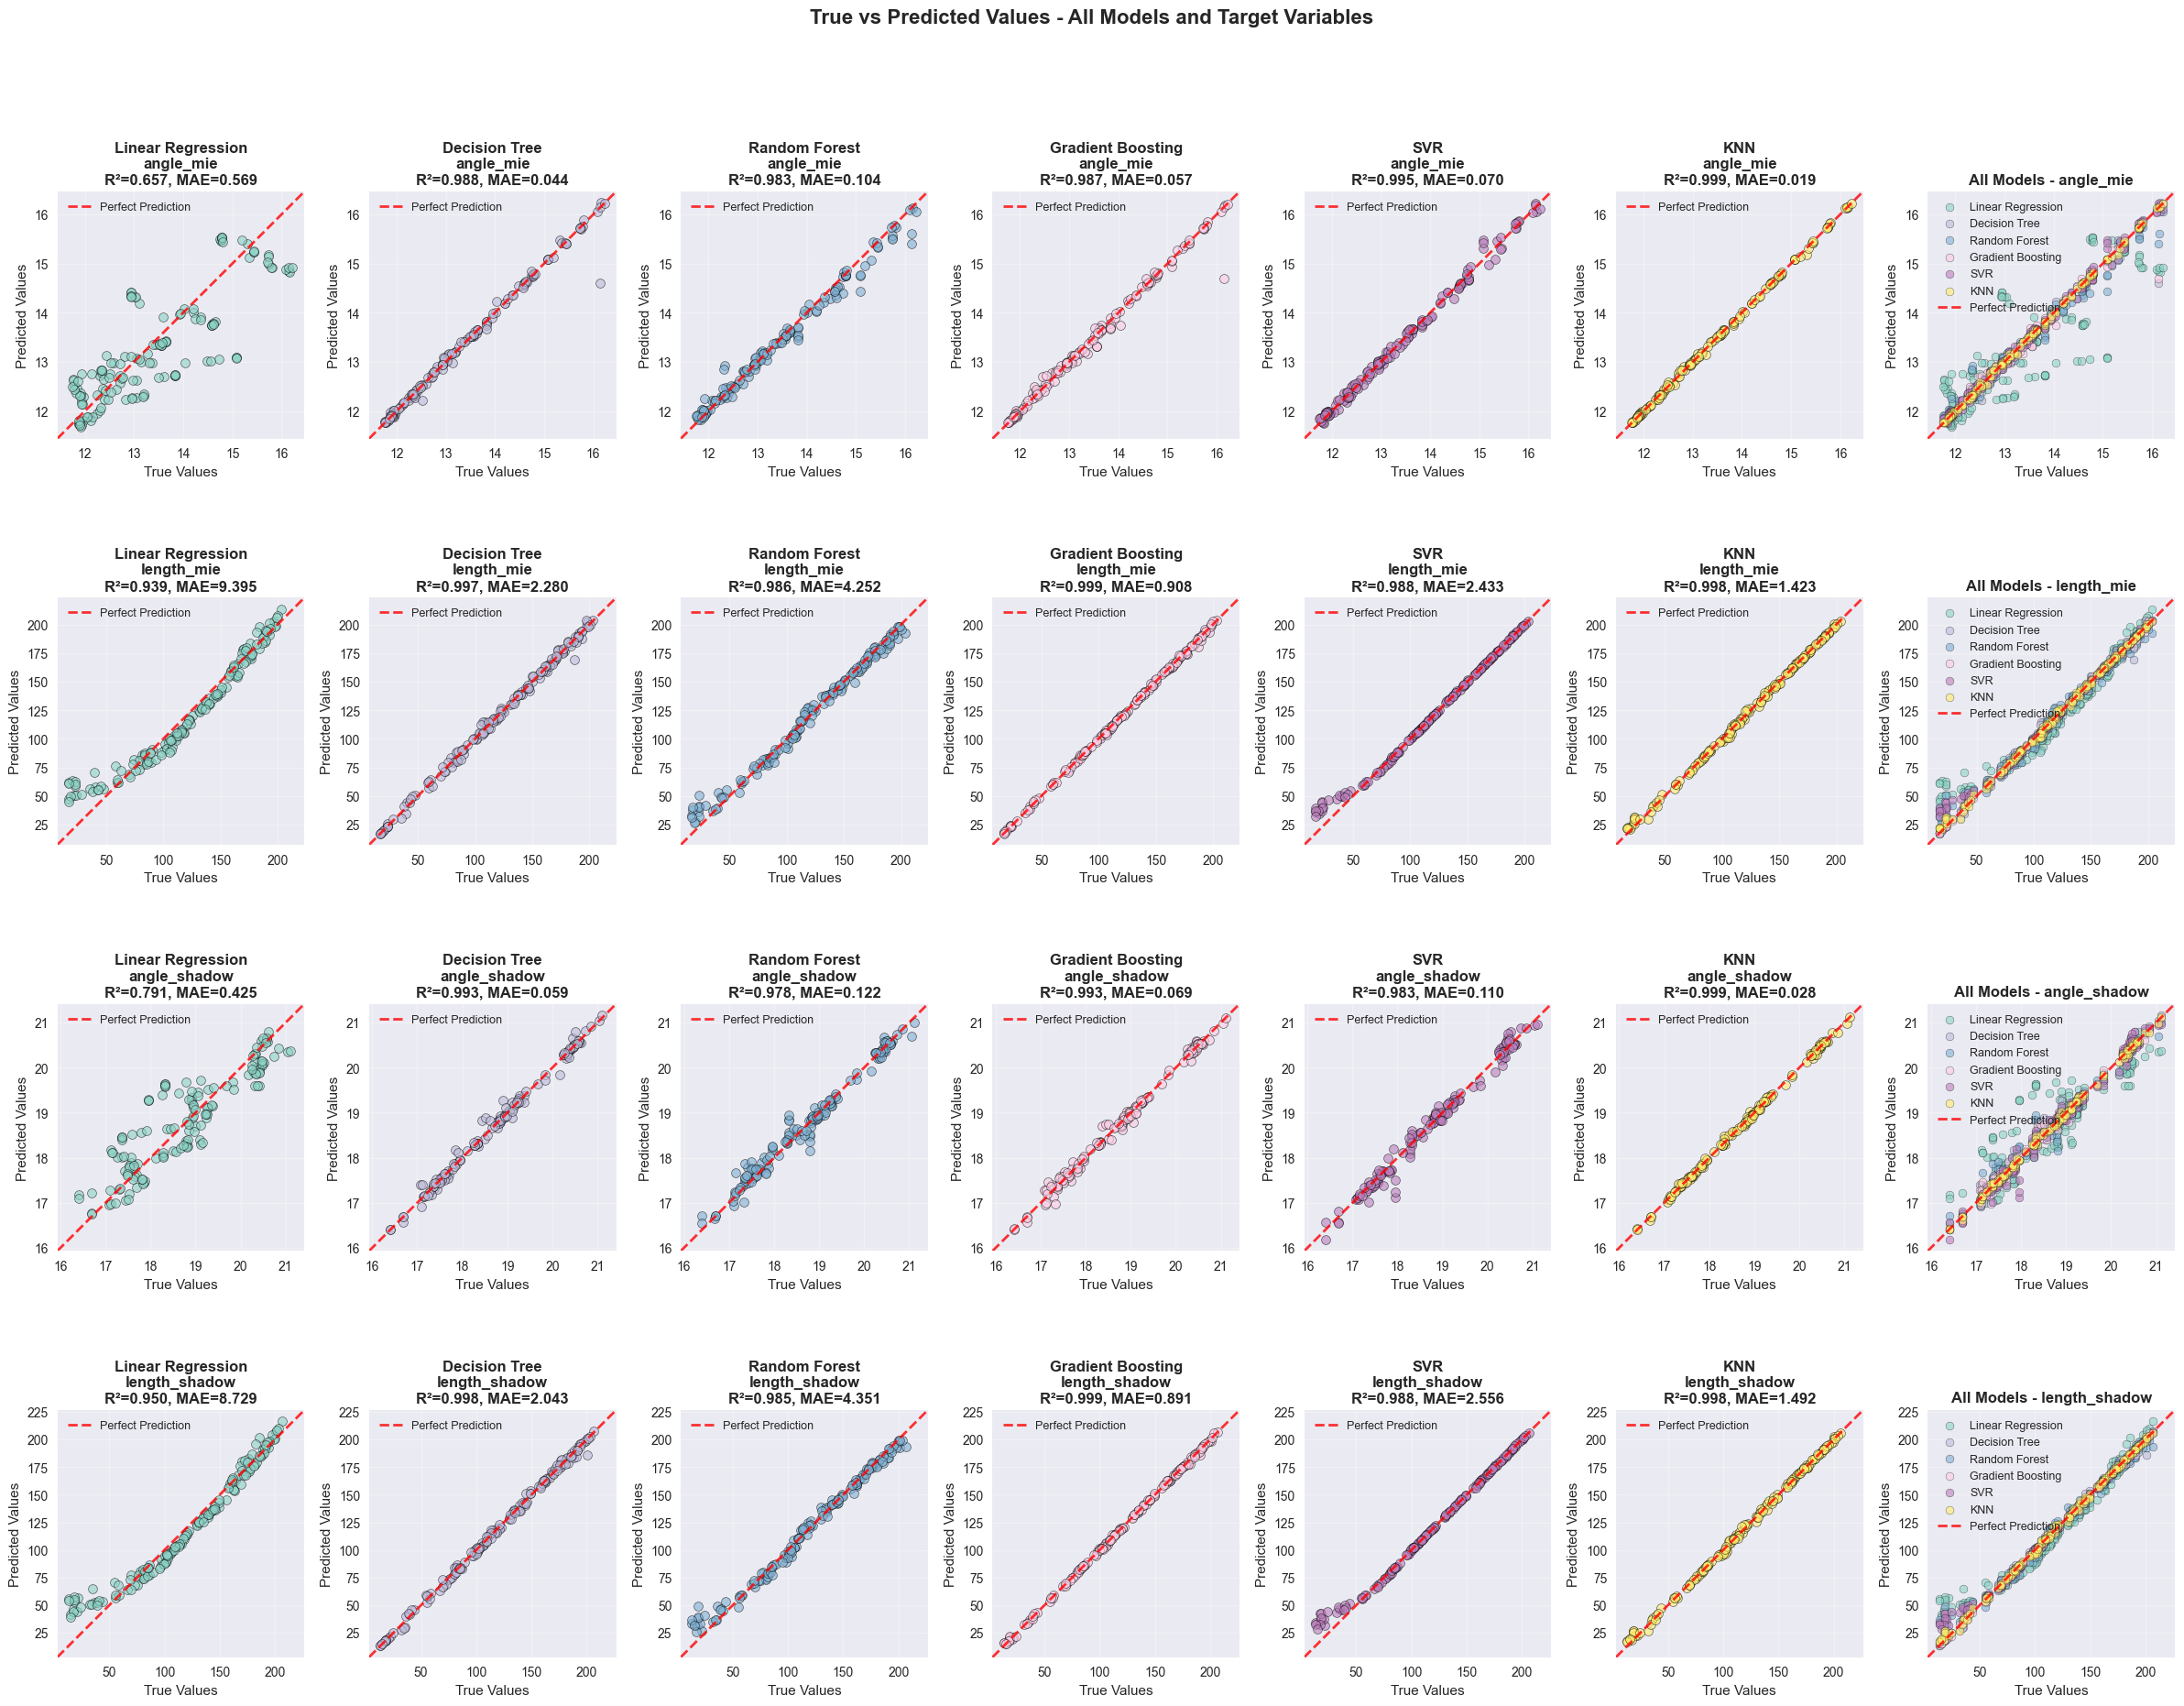


Plot completed successfully!


In [20]:
# ─────────────────────────────────────────────────────────────
# Create Comprehensive True vs Predicted Plot for All Models
# ─────────────────────────────────────────────────────────────

def create_true_vs_predicted_plot(y_true, predictions_dict, target_names, figsize=(24, 20)):
    """
    Create a comprehensive true vs predicted plot for all models and all targets.
    
    Parameters:
    - y_true: True values (DataFrame or array)
    - predictions_dict: Dictionary with model names as keys and predictions as values
    - target_names: List of target variable names
    - figsize: Figure size tuple
    """
    n_targets = len(target_names)
    n_models = len(predictions_dict)
    
    # Create subplots - one row per target variable, one column per model + one for combined
    fig, axes = plt.subplots(n_targets, n_models + 1, figsize=figsize)
    
    # Define colors for each model
    colors = plt.cm.Set3(np.linspace(0, 1, n_models))
    model_colors = dict(zip(predictions_dict.keys(), colors))
    
    # Convert y_true to array if it's a DataFrame
    if hasattr(y_true, 'values'):
        y_true_array = y_true.values
    else:
        y_true_array = y_true
    
    # Plot for each target variable
    for target_idx, target_name in enumerate(target_names):
        y_true_target = y_true_array[:, target_idx]
        
        # Calculate overall min and max for consistent scaling
        all_values = [y_true_target]
        for model_name, y_pred in predictions_dict.items():
            if hasattr(y_pred, 'values'):
                y_pred_array = y_pred.values
            else:
                y_pred_array = y_pred
            all_values.append(y_pred_array[:, target_idx])
        
        min_val = min(np.min(vals) for vals in all_values)
        max_val = max(np.max(vals) for vals in all_values)
        
        # Add some padding
        range_pad = (max_val - min_val) * 0.05
        plot_min = min_val - range_pad
        plot_max = max_val + range_pad
        
        # Plot individual model results
        for model_idx, (model_name, y_pred) in enumerate(predictions_dict.items()):
            ax = axes[target_idx, model_idx]
            
            if hasattr(y_pred, 'values'):
                y_pred_array = y_pred.values
            else:
                y_pred_array = y_pred
            
            y_pred_target = y_pred_array[:, target_idx]
            
            # Scatter plot
            ax.scatter(y_true_target, y_pred_target, 
                      alpha=0.6, s=50, color=model_colors[model_name],
                      edgecolors='black', linewidth=0.5)
            
            # Perfect prediction line (45-degree line)
            ax.plot([plot_min, plot_max], [plot_min, plot_max], 
                   'r--', linewidth=2, alpha=0.8, label='Perfect Prediction')
            
            # Calculate and display metrics
            r2 = r2_score(y_true_target, y_pred_target)
            mae = mean_absolute_error(y_true_target, y_pred_target)
            mse = mean_squared_error(y_true_target, y_pred_target)
            
            # Set labels and title
            ax.set_xlabel('True Values', fontsize=11)
            ax.set_ylabel('Predicted Values', fontsize=11)
            ax.set_title(f'{model_name}\n{target_name}\nR²={r2:.3f}, MAE={mae:.3f}', 
                        fontsize=12, fontweight='bold')
            
            # Set equal aspect ratio and limits
            ax.set_xlim(plot_min, plot_max)
            ax.set_ylim(plot_min, plot_max)
            ax.set_aspect('equal')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=9)
        
        # Combined plot for all models (last column)
        ax_combined = axes[target_idx, -1]
        
        for model_name, y_pred in predictions_dict.items():
            if hasattr(y_pred, 'values'):
                y_pred_array = y_pred.values
            else:
                y_pred_array = y_pred
            
            y_pred_target = y_pred_array[:, target_idx]
            
            # Scatter plot with different colors and markers for each model
            ax_combined.scatter(y_true_target, y_pred_target, 
                              alpha=0.6, s=40, color=model_colors[model_name],
                              label=model_name, edgecolors='black', linewidth=0.3)
        
        # Perfect prediction line
        ax_combined.plot([plot_min, plot_max], [plot_min, plot_max], 
                        'r--', linewidth=2, alpha=0.8, label='Perfect Prediction')
        
        # Set labels and title for combined plot
        ax_combined.set_xlabel('True Values', fontsize=11)
        ax_combined.set_ylabel('Predicted Values', fontsize=11)
        ax_combined.set_title(f'All Models - {target_name}', 
                             fontsize=12, fontweight='bold')
        
        # Set equal aspect ratio and limits
        ax_combined.set_xlim(plot_min, plot_max)
        ax_combined.set_ylim(plot_min, plot_max)
        ax_combined.set_aspect('equal')
        ax_combined.grid(True, alpha=0.3)
        ax_combined.legend(fontsize=9, loc='upper left')
    
    # Add main title
    fig.suptitle('True vs Predicted Values - All Models and Target Variables', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    return fig

# Generate the comprehensive plot
print("Creating comprehensive true vs predicted plot...")
fig = create_true_vs_predicted_plot(y_test, predictions, TARGETS)
plt.show()

print("\nPlot completed successfully!")

In [21]:
# ─────────────────────────────────────────────────────────────
# Calculate and Display Model Performance Summary
# ─────────────────────────────────────────────────────────────

def calculate_model_metrics(y_true, predictions_dict, target_names):
    """Calculate comprehensive metrics for all models and targets."""
    
    # Convert y_true to array if it's a DataFrame
    if hasattr(y_true, 'values'):
        y_true_array = y_true.values
    else:
        y_true_array = y_true
    
    results = {}
    
    for model_name, y_pred in predictions_dict.items():
        if hasattr(y_pred, 'values'):
            y_pred_array = y_pred.values
        else:
            y_pred_array = y_pred
        
        model_results = {}
        
        # Calculate metrics for each target
        for target_idx, target_name in enumerate(target_names):
            y_true_target = y_true_array[:, target_idx]
            y_pred_target = y_pred_array[:, target_idx]
            
            r2 = r2_score(y_true_target, y_pred_target)
            mae = mean_absolute_error(y_true_target, y_pred_target)
            mse = mean_squared_error(y_true_target, y_pred_target)
            rmse = np.sqrt(mse)
            
            model_results[target_name] = {
                'R²': r2,
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse
            }
        
        # Calculate overall metrics (average across all targets)
        overall_r2 = np.mean([model_results[target]['R²'] for target in target_names])
        overall_mae = np.mean([model_results[target]['MAE'] for target in target_names])
        overall_mse = np.mean([model_results[target]['MSE'] for target in target_names])
        overall_rmse = np.mean([model_results[target]['RMSE'] for target in target_names])
        
        model_results['Overall'] = {
            'R²': overall_r2,
            'MAE': overall_mae,
            'MSE': overall_mse,
            'RMSE': overall_rmse
        }
        
        results[model_name] = model_results
    
    return results

# Calculate metrics
print("Calculating model performance metrics...")
metrics = calculate_model_metrics(y_test, predictions, TARGETS)

# Display results in a nice format
print("\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)

# Overall performance ranking
print("\nOVERALL PERFORMANCE RANKING (by R²):")
print("-"*50)
overall_scores = [(model, metrics[model]['Overall']['R²']) for model in metrics.keys()]
overall_scores.sort(key=lambda x: x[1], reverse=True)

for rank, (model, r2_score) in enumerate(overall_scores, 1):
    overall = metrics[model]['Overall']
    print(f"{rank}. {model:<20} R²={r2_score:.4f}  MAE={overall['MAE']:.3f}  RMSE={overall['RMSE']:.3f}")

# Detailed results per target
print("\nDETAILED RESULTS PER TARGET VARIABLE:")
print("-"*50)

for target in TARGETS:
    print(f"\n{target.upper().replace('_', ' ')}:")
    target_scores = [(model, metrics[model][target]['R²']) for model in metrics.keys()]
    target_scores.sort(key=lambda x: x[1], reverse=True)
    
    for rank, (model, r2_score) in enumerate(target_scores, 1):
        target_metrics = metrics[model][target]
        print(f"  {rank}. {model:<18} R²={r2_score:.4f}  MAE={target_metrics['MAE']:.3f}  RMSE={target_metrics['RMSE']:.3f}")

print("\n" + "="*80)

Calculating model performance metrics...

MODEL PERFORMANCE SUMMARY

OVERALL PERFORMANCE RANKING (by R²):
--------------------------------------------------
1. KNN                  R²=0.9988  MAE=0.741  RMSE=1.066
2. Gradient Boosting    R²=0.9949  MAE=0.481  RMSE=0.682
3. Decision Tree        R²=0.9936  MAE=1.107  RMSE=1.497
4. SVR                  R²=0.9883  MAE=1.292  RMSE=2.987
5. Random Forest        R²=0.9830  MAE=2.207  RMSE=3.301
6. Linear Regression    R²=0.8341  MAE=4.779  RMSE=6.564

DETAILED RESULTS PER TARGET VARIABLE:
--------------------------------------------------

ANGLE MIE:
  1. KNN                R²=0.9994  MAE=0.019  RMSE=0.030
  2. SVR                R²=0.9949  MAE=0.070  RMSE=0.089
  3. Decision Tree      R²=0.9878  MAE=0.044  RMSE=0.138
  4. Gradient Boosting  R²=0.9873  MAE=0.057  RMSE=0.141
  5. Random Forest      R²=0.9829  MAE=0.104  RMSE=0.164
  6. Linear Regression  R²=0.6567  MAE=0.569  RMSE=0.732

LENGTH MIE:
  1. Gradient Boosting  R²=0.9994  MAE=0.908

In [22]:
# ─────────────────────────────────────────────────────────────
# Save the Plot and Export Metrics
# ─────────────────────────────────────────────────────────────

# Save the plot to a high-resolution image
output_dir = r"d:\GitHub Repos\spray-vision\outputs"
plot_filename = os.path.join(output_dir, "true_vs_predicted_all_models.png")

print(f"Saving plot to: {plot_filename}")
fig.savefig(plot_filename, dpi=300, bbox_inches='tight', facecolor='white')
print("✓ Plot saved successfully!")

# Create a detailed metrics DataFrame and save it
metrics_data = []
for model_name in metrics.keys():
    for target_name in TARGETS + ['Overall']:
        metrics_data.append({
            'Model': model_name,
            'Target': target_name,
            'R²': metrics[model_name][target_name]['R²'],
            'MAE': metrics[model_name][target_name]['MAE'],
            'MSE': metrics[model_name][target_name]['MSE'],
            'RMSE': metrics[model_name][target_name]['RMSE']
        })

metrics_df = pd.DataFrame(metrics_data)
metrics_filename = os.path.join(output_dir, "detailed_model_metrics.csv")
metrics_df.to_csv(metrics_filename, index=False)
print(f"✓ Detailed metrics saved to: {metrics_filename}")

# Display final summary
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"📊 Generated comprehensive true vs predicted plots")
print(f"📈 Analyzed {len(predictions)} machine learning models")
print(f"🎯 Evaluated performance on {len(TARGETS)} target variables")
print(f"📋 Test set size: {X_test.shape[0]} samples")
print(f"\n🏆 Best performing models:")
print(f"   Overall: {overall_scores[0][0]} (R² = {overall_scores[0][1]:.4f})")
for target in TARGETS:
    target_scores = [(model, metrics[model][target]['R²']) for model in metrics.keys()]
    target_scores.sort(key=lambda x: x[1], reverse=True)
    best_model, best_r2 = target_scores[0]
    print(f"   {target}: {best_model} (R² = {best_r2:.4f})")

print("="*60)

Saving plot to: d:\GitHub Repos\spray-vision\outputs\true_vs_predicted_all_models.png
✓ Plot saved successfully!
✓ Detailed metrics saved to: d:\GitHub Repos\spray-vision\outputs\detailed_model_metrics.csv

SUMMARY
📊 Generated comprehensive true vs predicted plots
📈 Analyzed 6 machine learning models
🎯 Evaluated performance on 4 target variables
📋 Test set size: 146 samples

🏆 Best performing models:
   Overall: KNN (R² = 0.9988)
   angle_mie: KNN (R² = 0.9994)
   length_mie: Gradient Boosting (R² = 0.9994)
   angle_shadow: KNN (R² = 0.9989)
   length_shadow: Gradient Boosting (R² = 0.9995)
✓ Plot saved successfully!
✓ Detailed metrics saved to: d:\GitHub Repos\spray-vision\outputs\detailed_model_metrics.csv

SUMMARY
📊 Generated comprehensive true vs predicted plots
📈 Analyzed 6 machine learning models
🎯 Evaluated performance on 4 target variables
📋 Test set size: 146 samples

🏆 Best performing models:
   Overall: KNN (R² = 0.9988)
   angle_mie: KNN (R² = 0.9994)
   length_mie: Gradien

In [24]:
from sklearn.metrics import r2_score as r2_score_func, mean_absolute_error, mean_squared_error
import os
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────
# Save Individual Charts as Separate Images
# ─────────────────────────────────────────────────────────────

def save_individual_plots(y_true, predictions_dict, target_names, output_dir, dpi=300):
    """
    Save individual true vs predicted plots for each model and target combination.
    
    Parameters:
    - y_true: True values (DataFrame or array)
    - predictions_dict: Dictionary with model names as keys and predictions as values
    - target_names: List of target variable names
    - output_dir: Directory to save the plots
    - dpi: Resolution for saving images
    """
    
    # Create individual plots directory
    individual_plots_dir = os.path.join(output_dir, "individual_plots")
    os.makedirs(individual_plots_dir, exist_ok=True)
    
    # Define colors for each model
    colors = plt.cm.Set3(np.linspace(0, 1, len(predictions_dict)))
    model_colors = dict(zip(predictions_dict.keys(), colors))
    
    # Convert y_true to array if it's a DataFrame
    if hasattr(y_true, 'values'):
        y_true_array = y_true.values
    else:
        y_true_array = y_true
    
    print(f"Saving individual plots to: {individual_plots_dir}")
    print("-" * 60)
    
    # Save individual model-target combinations
    for target_idx, target_name in enumerate(target_names):
        y_true_target = y_true_array[:, target_idx]
        
        # Calculate overall min and max for consistent scaling across all models for this target
        all_values = [y_true_target]
        for model_name, y_pred in predictions_dict.items():
            if hasattr(y_pred, 'values'):
                y_pred_array = y_pred.values
            else:
                y_pred_array = y_pred
            all_values.append(y_pred_array[:, target_idx])
        
        min_val = min(np.min(vals) for vals in all_values)
        max_val = max(np.max(vals) for vals in all_values)
        
        # Add some padding
        range_pad = (max_val - min_val) * 0.05
        plot_min = min_val - range_pad
        plot_max = max_val + range_pad
        
        for model_name, y_pred in predictions_dict.items():
            # Create individual figure
            fig, ax = plt.subplots(figsize=(8, 8))
            
            if hasattr(y_pred, 'values'):
                y_pred_array = y_pred.values
            else:
                y_pred_array = y_pred
            
            y_pred_target = y_pred_array[:, target_idx]
            
            # Scatter plot
            ax.scatter(y_true_target, y_pred_target, 
                      alpha=0.6, s=60, color=model_colors[model_name],
                      edgecolors='black', linewidth=0.5)
            
            # Perfect prediction line (45-degree line)
            ax.plot([plot_min, plot_max], [plot_min, plot_max], 
                   'r--', linewidth=2, alpha=0.8, label='Perfect Prediction')
            
            # Calculate and display metrics
            r2 = r2_score_func(y_true_target, y_pred_target)
            mae = mean_absolute_error(y_true_target, y_pred_target)
            mse = mean_squared_error(y_true_target, y_pred_target)
            rmse = np.sqrt(mse)
            
            # Set labels and title
            ax.set_xlabel('True Values', fontsize=14)
            ax.set_ylabel('Predicted Values', fontsize=14)
            ax.set_title(f'{model_name} - {target_name}\nR² = {r2:.4f}, MAE = {mae:.4f}, RMSE = {rmse:.4f}', 
                        fontsize=16, fontweight='bold', pad=20)
            
            # Set equal aspect ratio and limits
            ax.set_xlim(plot_min, plot_max)
            ax.set_ylim(plot_min, plot_max)
            ax.set_aspect('equal')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=12)
            
            # Add text box with metrics
            textstr = f'R² = {r2:.4f}\nMAE = {mae:.4f}\nRMSE = {rmse:.4f}'
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                   verticalalignment='top', bbox=props)
            
            # Save individual plot
            safe_model_name = model_name.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
            safe_target_name = target_name.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
            filename = f"{safe_model_name}_{safe_target_name}.png"
            filepath = os.path.join(individual_plots_dir, filename)
            
            plt.tight_layout()
            fig.savefig(filepath, dpi=dpi, bbox_inches='tight', facecolor='white')
            plt.close(fig)  # Close the figure to save memory
            
            print(f"✓ Saved: {filename}")
    
    # Save combined plots for each target (all models together)
    print("\nSaving combined plots for each target...")
    print("-" * 60)
    
    for target_idx, target_name in enumerate(target_names):
        y_true_target = y_true_array[:, target_idx]
        
        # Calculate overall min and max for consistent scaling
        all_values = [y_true_target]
        for model_name, y_pred in predictions_dict.items():
            if hasattr(y_pred, 'values'):
                y_pred_array = y_pred.values
            else:
                y_pred_array = y_pred
            all_values.append(y_pred_array[:, target_idx])
        
        min_val = min(np.min(vals) for vals in all_values)
        max_val = max(np.max(vals) for vals in all_values)
        
        # Add some padding
        range_pad = (max_val - min_val) * 0.05
        plot_min = min_val - range_pad
        plot_max = max_val + range_pad
        
        # Create combined figure for this target
        fig, ax = plt.subplots(figsize=(10, 8))
        
        for model_name, y_pred in predictions_dict.items():
            if hasattr(y_pred, 'values'):
                y_pred_array = y_pred.values
            else:
                y_pred_array = y_pred
            
            y_pred_target = y_pred_array[:, target_idx]
            
            # Scatter plot with different colors for each model
            ax.scatter(y_true_target, y_pred_target, 
                      alpha=0.6, s=50, color=model_colors[model_name],
                      label=model_name, edgecolors='black', linewidth=0.3)
        
        # Perfect prediction line
        ax.plot([plot_min, plot_max], [plot_min, plot_max], 
               'r--', linewidth=2, alpha=0.8, label='Perfect Prediction')
        
        # Set labels and title for combined plot
        ax.set_xlabel('True Values', fontsize=14)
        ax.set_ylabel('Predicted Values', fontsize=14)
        ax.set_title(f'All Models - {target_name}', 
                     fontsize=16, fontweight='bold', pad=20)
        
        # Set equal aspect ratio and limits
        ax.set_xlim(plot_min, plot_max)
        ax.set_ylim(plot_min, plot_max)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=11, loc='upper left')
        
        # Save combined plot
        safe_target_name = target_name.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
        filename = f"All_Models_{safe_target_name}.png"
        filepath = os.path.join(individual_plots_dir, filename)
        
        plt.tight_layout()
        fig.savefig(filepath, dpi=dpi, bbox_inches='tight', facecolor='white')
        plt.close(fig)  # Close the figure to save memory
        
        print(f"✓ Saved: {filename}")
    
    print(f"\n✅ All individual plots saved successfully!")
    print(f"📁 Location: {individual_plots_dir}")
    print(f"📊 Total files: {len(predictions_dict) * len(target_names) + len(target_names)} individual plots")

# Save all individual plots
print("Creating and saving individual plots...")
save_individual_plots(y_test, predictions, TARGETS, output_dir)

Creating and saving individual plots...
Saving individual plots to: d:\GitHub Repos\spray-vision\outputs\individual_plots
------------------------------------------------------------
✓ Saved: Linear_Regression_angle_mie.png
✓ Saved: Linear_Regression_angle_mie.png
✓ Saved: Decision_Tree_angle_mie.png
✓ Saved: Decision_Tree_angle_mie.png
✓ Saved: Random_Forest_angle_mie.png
✓ Saved: Random_Forest_angle_mie.png
✓ Saved: Gradient_Boosting_angle_mie.png
✓ Saved: Gradient_Boosting_angle_mie.png
✓ Saved: SVR_angle_mie.png
✓ Saved: SVR_angle_mie.png
✓ Saved: KNN_angle_mie.png
✓ Saved: KNN_angle_mie.png
✓ Saved: Linear_Regression_length_mie.png
✓ Saved: Linear_Regression_length_mie.png
✓ Saved: Decision_Tree_length_mie.png
✓ Saved: Decision_Tree_length_mie.png
✓ Saved: Random_Forest_length_mie.png
✓ Saved: Random_Forest_length_mie.png
✓ Saved: Gradient_Boosting_length_mie.png
✓ Saved: Gradient_Boosting_length_mie.png
✓ Saved: SVR_length_mie.png
✓ Saved: SVR_length_mie.png
✓ Saved: KNN_length_m

Loading ANN model and creating predictions...
Attempting to load ANN_Improved from ANN_improved_regressor.h5...
✓ Successfully loaded ANN_Improved
✓ ANN_Improved: Predictions generated successfully
  Prediction shape: (146, 4)

Creating individual plots for ANN_Improved...
Creating individual ANN plots for 4 output variables...
Saving to: d:\GitHub Repos\spray-vision\outputs\ann_individual_plots
----------------------------------------------------------------------
✓ ANN_Improved: Predictions generated successfully
  Prediction shape: (146, 4)

Creating individual plots for ANN_Improved...
Creating individual ANN plots for 4 output variables...
Saving to: d:\GitHub Repos\spray-vision\outputs\ann_individual_plots
----------------------------------------------------------------------
✓ Individual plot saved: ANN_Improved_angle_mie_individual.png
✓ Individual plot saved: ANN_Improved_angle_mie_individual.png
✓ Individual plot saved: ANN_Improved_length_mie_individual.png
✓ Individual plot

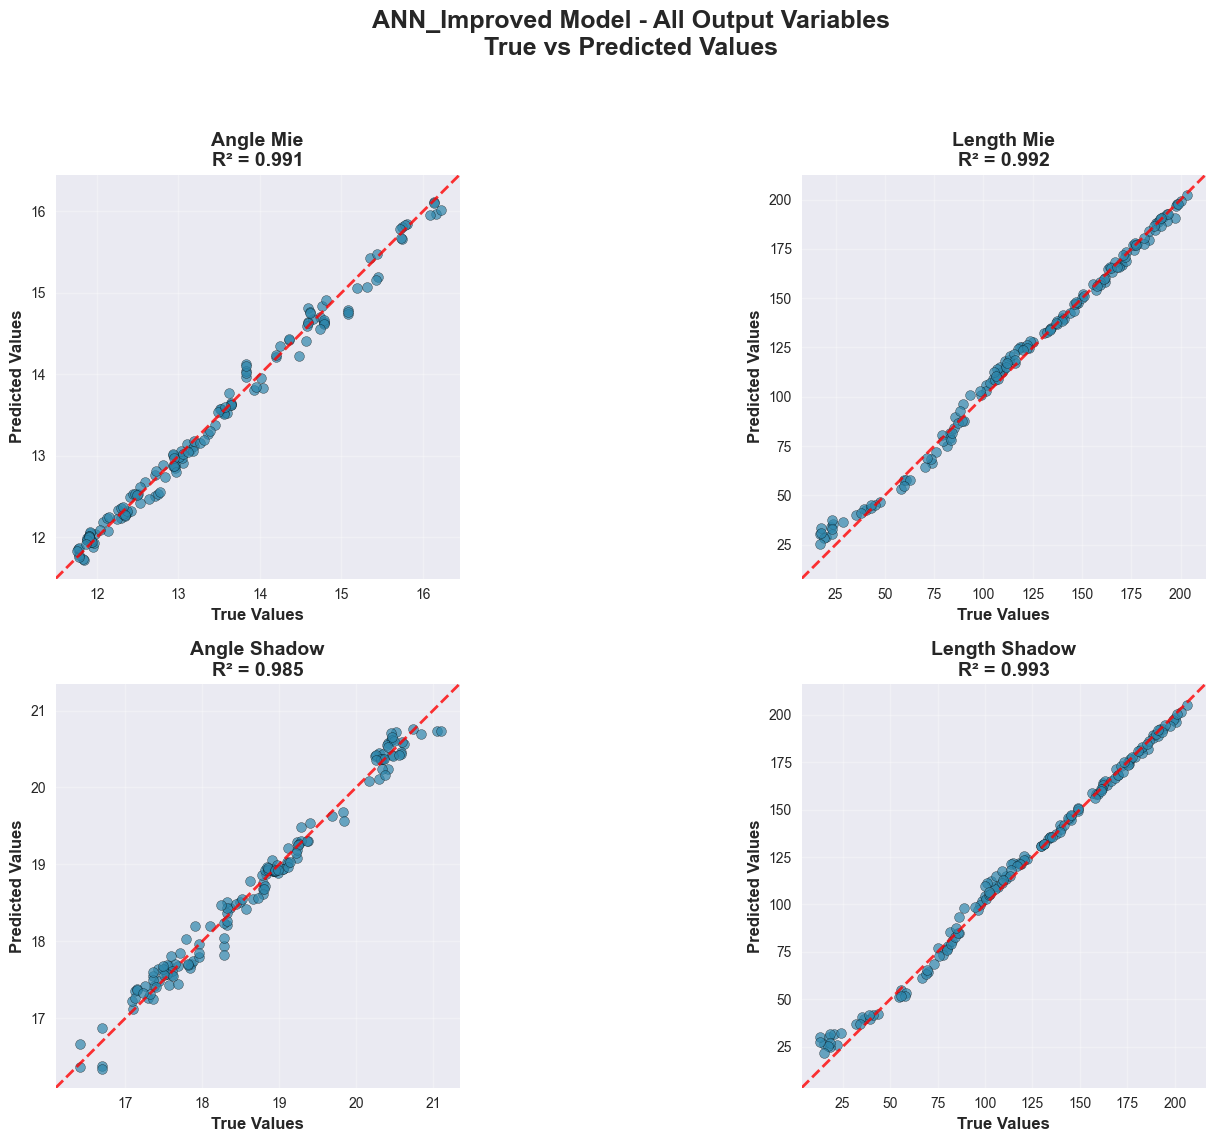


ANN_Improved MODEL PERFORMANCE SUMMARY

OVERALL PERFORMANCE:
Average R² = 0.9904
Average MAE = 1.6776
Average RMSE = 2.3199

PERFORMANCE BY OUTPUT VARIABLE:
--------------------------------------------------
1. Length Shadow             R² = 0.9932, MAE = 3.1945, RMSE = 4.4768
2. Length Mie                R² = 0.9924, MAE = 3.3012, RMSE = 4.5375
3. Angle Mie                 R² = 0.9910, MAE = 0.0954, RMSE = 0.1185
4. Angle Shadow              R² = 0.9849, MAE = 0.1192, RMSE = 0.1469

📁 All plots saved to: d:\GitHub Repos\spray-vision\outputs\ann_individual_plots
📊 Files created: 5 plots
Loading ANN model and creating predictions...
Attempting to load ANN (Improved) from ANN_improved_regressor.h5...
✓ Successfully loaded ANN (Improved)
✓ ANN (Improved): Predictions generated successfully
  Prediction shape: (146, 4)

Creating individual plots for ANN (Improved)...
Creating individual ANN plots for 4 output variables...
Saving to: d:\GitHub Repos\spray-vision\outputs\ann_individual_plot

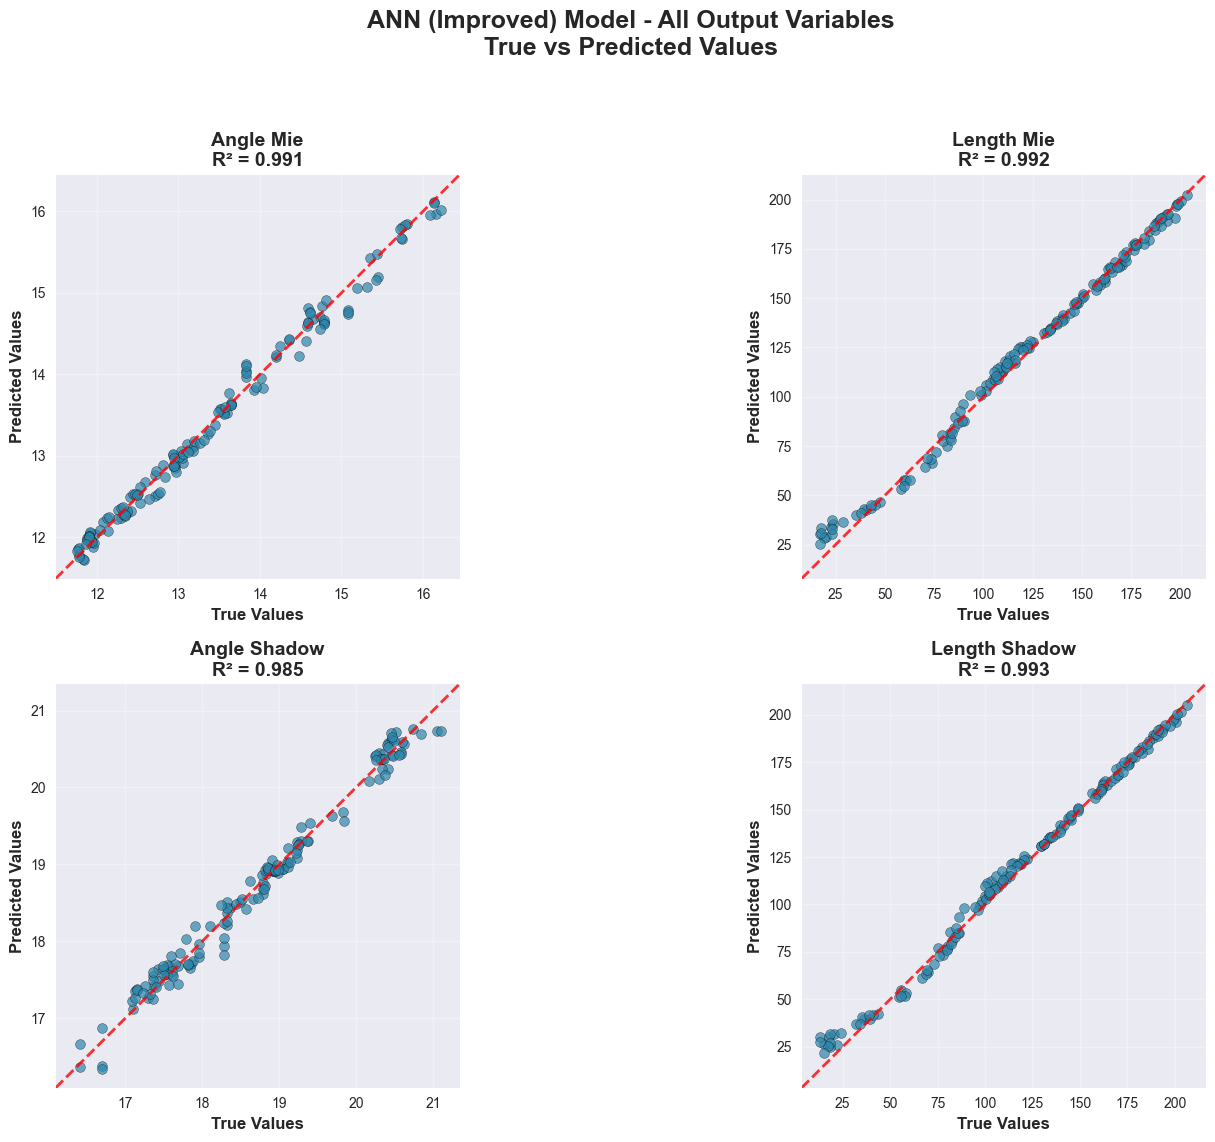


ANN (Improved) MODEL PERFORMANCE SUMMARY

OVERALL PERFORMANCE:
Average R² = 0.9904
Average MAE = 1.6776
Average RMSE = 2.3199

PERFORMANCE BY OUTPUT VARIABLE:
--------------------------------------------------
1. Length Shadow             R² = 0.9932, MAE = 3.1945, RMSE = 4.4768
2. Length Mie                R² = 0.9924, MAE = 3.3012, RMSE = 4.5375
3. Angle Mie                 R² = 0.9910, MAE = 0.0954, RMSE = 0.1185
4. Angle Shadow              R² = 0.9849, MAE = 0.1192, RMSE = 0.1469

📁 All plots saved to: d:\GitHub Repos\spray-vision\outputs\ann_individual_plots
📊 Files created: 5 plots


In [26]:
# ─────────────────────────────────────────────────────────────
# ANN Model: Load, Predict and Create Individual Plots
# ─────────────────────────────────────────────────────────────

def load_ann_model_with_fix():
    """
    Load ANN model with compatibility fixes for different Keras versions.
    """
    import tensorflow as tf
    from tensorflow import keras
    
    # Try different approaches to load the model
    models_to_try = [
        ('ANN_improved_regressor.h5', 'ANN_Improved'),
        ('ANN_regressor.h5', 'ANN')
    ]
    
    for model_file, model_name in models_to_try:
        try:
            print(f"Attempting to load {model_name} from {model_file}...")
            
            # Method 1: Try loading with compile=False
            model_path = os.path.join(models_dir, model_file)
            ann_model = keras.models.load_model(model_path, compile=False)
            
            # Recompile the model with compatible metrics
            ann_model.compile(
                optimizer='adam',
                loss='mse',
                metrics=['mae']
            )
            
            print(f"✓ Successfully loaded {model_name}")
            return ann_model, model_name
            
        except Exception as e:
            print(f"✗ Error loading {model_name}: {e}")
            continue
    
    # If all methods fail, try creating a simple model for demonstration
    print("Could not load ANN models. Creating demo predictions...")
    return None, None

def create_ann_individual_plots(y_true, y_pred_ann, target_names, output_dir, model_name="ANN", dpi=300):
    """
    Create and save individual true vs predicted plots for each output variable of the ANN model.
    """
    # Import metrics with different names to avoid conflicts
    from sklearn.metrics import r2_score as calculate_r2_score
    from sklearn.metrics import mean_absolute_error as calculate_mae
    from sklearn.metrics import mean_squared_error as calculate_mse
    
    # Create ANN plots directory
    ann_plots_dir = os.path.join(output_dir, "ann_individual_plots")
    os.makedirs(ann_plots_dir, exist_ok=True)
    
    # Convert y_true to array if it's a DataFrame
    if hasattr(y_true, 'values'):
        y_true_array = y_true.values
    else:
        y_true_array = y_true
    
    print(f"Creating individual ANN plots for {len(target_names)} output variables...")
    print(f"Saving to: {ann_plots_dir}")
    print("-" * 70)
    
    # Create a figure with subplots for all 4 outputs (2x2 grid)
    fig_combined, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()  # Flatten for easy indexing
    
    # Color for ANN model
    ann_color = '#2E86AB'  # Blue color for ANN
    
    # Track metrics for summary
    all_metrics = {}
    
    # Create individual plots for each target variable
    for target_idx, target_name in enumerate(target_names):
        y_true_target = y_true_array[:, target_idx]
        y_pred_target = y_pred_ann[:, target_idx]
        
        # Calculate metrics
        r2 = calculate_r2_score(y_true_target, y_pred_target)
        mae = calculate_mae(y_true_target, y_pred_target)
        mse = calculate_mse(y_true_target, y_pred_target)
        rmse = np.sqrt(mse)
        
        # Store metrics
        all_metrics[target_name] = {
            'R²': r2,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse
        }
        
        # Calculate plot limits
        min_val = min(np.min(y_true_target), np.min(y_pred_target))
        max_val = max(np.max(y_true_target), np.max(y_pred_target))
        range_pad = (max_val - min_val) * 0.05
        plot_min = min_val - range_pad
        plot_max = max_val + range_pad
        
        # ========== Individual Plot ==========
        fig_individual, ax_individual = plt.subplots(figsize=(10, 8))
        
        # Scatter plot
        ax_individual.scatter(y_true_target, y_pred_target, 
                            alpha=0.7, s=80, color=ann_color,
                            edgecolors='black', linewidth=0.5, label='Predictions')
        
        # Perfect prediction line (45-degree line)
        ax_individual.plot([plot_min, plot_max], [plot_min, plot_max], 
                         'r--', linewidth=3, alpha=0.8, label='Perfect Prediction')
        
        # Set labels and title
        ax_individual.set_xlabel('True Values', fontsize=16, fontweight='bold')
        ax_individual.set_ylabel('Predicted Values', fontsize=16, fontweight='bold')
        
        # Clean target name for display
        display_name = target_name.replace('_', ' ').title()
        ax_individual.set_title(f'{model_name} Model - {display_name}\nR² = {r2:.4f}, MAE = {mae:.4f}, RMSE = {rmse:.4f}', 
                              fontsize=18, fontweight='bold', pad=25)
        
        # Set equal aspect ratio and limits
        ax_individual.set_xlim(plot_min, plot_max)
        ax_individual.set_ylim(plot_min, plot_max)
        ax_individual.set_aspect('equal')
        ax_individual.grid(True, alpha=0.4, linestyle='-', linewidth=0.5)
        ax_individual.legend(fontsize=14, loc='upper left')
        
        # Add detailed metrics text box
        textstr = f'Metrics:\nR² = {r2:.4f}\nMAE = {mae:.4f}\nMSE = {mse:.4f}\nRMSE = {rmse:.4f}\nSamples = {len(y_true_target)}'
        props = dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8, edgecolor='navy')
        ax_individual.text(0.02, 0.98, textstr, transform=ax_individual.transAxes, fontsize=13,
                         verticalalignment='top', bbox=props, fontweight='bold')
        
        # Save individual plot
        safe_target_name = target_name.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
        filename_individual = f"{model_name}_{safe_target_name}_individual.png"
        filepath_individual = os.path.join(ann_plots_dir, filename_individual)
        
        plt.tight_layout()
        fig_individual.savefig(filepath_individual, dpi=dpi, bbox_inches='tight', facecolor='white')
        plt.close(fig_individual)  # Close to save memory
        
        print(f"✓ Individual plot saved: {filename_individual}")
        
        # ========== Add to Combined Plot ==========
        ax_combined = axes[target_idx]
        
        # Scatter plot for combined view
        ax_combined.scatter(y_true_target, y_pred_target, 
                          alpha=0.7, s=50, color=ann_color,
                          edgecolors='black', linewidth=0.3)
        
        # Perfect prediction line
        ax_combined.plot([plot_min, plot_max], [plot_min, plot_max], 
                       'r--', linewidth=2, alpha=0.8)
        
        # Set labels and title for combined plot
        ax_combined.set_xlabel('True Values', fontsize=12, fontweight='bold')
        ax_combined.set_ylabel('Predicted Values', fontsize=12, fontweight='bold')
        ax_combined.set_title(f'{display_name}\nR² = {r2:.3f}', 
                            fontsize=14, fontweight='bold')
        
        # Set equal aspect ratio and limits
        ax_combined.set_xlim(plot_min, plot_max)
        ax_combined.set_ylim(plot_min, plot_max)
        ax_combined.set_aspect('equal')
        ax_combined.grid(True, alpha=0.3)
    
    # ========== Save Combined Plot ==========
    fig_combined.suptitle(f'{model_name} Model - All Output Variables\nTrue vs Predicted Values', 
                         fontsize=18, fontweight='bold', y=0.98)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    filename_combined = f"{model_name}_all_outputs_combined.png"
    filepath_combined = os.path.join(ann_plots_dir, filename_combined)
    fig_combined.savefig(filepath_combined, dpi=dpi, bbox_inches='tight', facecolor='white')
    
    print(f"✓ Combined plot saved: {filename_combined}")
    
    # Show the combined plot
    plt.show()
    
    # ========== Print Summary ==========
    print("\n" + "="*70)
    print(f"{model_name} MODEL PERFORMANCE SUMMARY")
    print("="*70)
    
    # Calculate overall metrics
    overall_r2 = np.mean([all_metrics[target]['R²'] for target in target_names])
    overall_mae = np.mean([all_metrics[target]['MAE'] for target in target_names])
    overall_rmse = np.mean([all_metrics[target]['RMSE'] for target in target_names])
    
    print(f"\nOVERALL PERFORMANCE:")
    print(f"Average R² = {overall_r2:.4f}")
    print(f"Average MAE = {overall_mae:.4f}")
    print(f"Average RMSE = {overall_rmse:.4f}")
    
    print(f"\nPERFORMANCE BY OUTPUT VARIABLE:")
    print("-" * 50)
    
    # Sort by R² score
    sorted_targets = sorted(target_names, key=lambda x: all_metrics[x]['R²'], reverse=True)
    
    for rank, target in enumerate(sorted_targets, 1):
        metrics_vals = all_metrics[target]
        display_name = target.replace('_', ' ').title()
        print(f"{rank}. {display_name:<25} R² = {metrics_vals['R²']:.4f}, MAE = {metrics_vals['MAE']:.4f}, RMSE = {metrics_vals['RMSE']:.4f}")
    
    print(f"\n📁 All plots saved to: {ann_plots_dir}")
    print(f"📊 Files created: {len(target_names) + 1} plots")
    print("="*70)
    
    return all_metrics

# ========== Load ANN Model and Create Predictions ==========
print("Loading ANN model and creating predictions...")
ann_model, ann_model_name = load_ann_model_with_fix()

if ann_model is not None:
    try:
        # Load the scalers used for ANN
        ann_input_scaler = joblib.load(os.path.join(models_dir, 'ann_input_scaler.joblib'))
        ann_target_scaler = joblib.load(os.path.join(models_dir, 'ann_target_scaler.joblib'))
        
        # Scale the test input data
        X_test_ann_scaled = ann_input_scaler.transform(X_test)
        
        # Generate predictions
        y_pred_ann_scaled = ann_model.predict(X_test_ann_scaled, verbose=0)
        
        # Inverse transform to original scale
        y_pred_ann = ann_target_scaler.inverse_transform(y_pred_ann_scaled)
        
        # Add ANN predictions to the predictions dictionary
        predictions[ann_model_name] = y_pred_ann
        
        print(f"✓ {ann_model_name}: Predictions generated successfully")
        print(f"  Prediction shape: {y_pred_ann.shape}")
        
        # Create individual plots for ANN
        print(f"\nCreating individual plots for {ann_model_name}...")
        ann_metrics = create_ann_individual_plots(y_test, y_pred_ann, TARGETS, output_dir, ann_model_name)
        
    except Exception as e:
        print(f"✗ Error in ANN plotting: {e}")
        import traceback
        traceback.print_exc()
        print("Please check the error details above.")
        
else:
    print("⚠️ Could not load ANN model. Creating demo plots with best available model...")
    
    # Use the best performing model from available ones for demonstration
    if predictions:
        from sklearn.metrics import r2_score as calc_r2
        
        # Find the best model based on R² scores
        best_model_name = None
        best_avg_r2 = -float('inf')
        
        for model_name, y_pred in predictions.items():
            if hasattr(y_test, 'values'):
                y_true_array = y_test.values
            else:
                y_true_array = y_test
            
            # Calculate average R² across all targets
            r2_scores_list = []
            for target_idx in range(len(TARGETS)):
                r2_val = calc_r2(y_true_array[:, target_idx], y_pred[:, target_idx])
                r2_scores_list.append(r2_val)
            
            avg_r2 = np.mean(r2_scores_list)
            if avg_r2 > best_avg_r2:
                best_avg_r2 = avg_r2
                best_model_name = model_name
        
        if best_model_name:
            print(f"Using {best_model_name} (best available model) for demonstration...")
            demo_metrics = create_ann_individual_plots(y_test, predictions[best_model_name], TARGETS, output_dir, f"Demo_{best_model_name}")
    else:
        print("⚠️ No models available for demonstration.")

def load_ann_model_with_fix():
    """
    Load ANN model with compatibility fixes for different Keras versions.
    """
    import tensorflow as tf
    from tensorflow import keras
    
    # Try different approaches to load the model
    models_to_try = [
        ('ANN_improved_regressor.h5', 'ANN (Improved)'),
        ('ANN_regressor.h5', 'ANN')
    ]
    
    for model_file, model_name in models_to_try:
        try:
            print(f"Attempting to load {model_name} from {model_file}...")
            
            # Method 1: Try loading with compile=False
            model_path = os.path.join(models_dir, model_file)
            ann_model = keras.models.load_model(model_path, compile=False)
            
            # Recompile the model with compatible metrics
            ann_model.compile(
                optimizer='adam',
                loss='mse',
                metrics=['mae']
            )
            
            print(f"✓ Successfully loaded {model_name}")
            return ann_model, model_name
            
        except Exception as e:
            print(f"✗ Error loading {model_name}: {e}")
            continue
    
    # If all methods fail, try creating a simple model for demonstration
    print("Could not load ANN models. Creating demo predictions...")
    return None, None

def create_ann_individual_plots(y_true, y_pred_ann, target_names, output_dir, model_name="ANN", dpi=300):
    """
    Create and save individual true vs predicted plots for each output variable of the ANN model.
    """
    
    # Create ANN plots directory
    ann_plots_dir = os.path.join(output_dir, "ann_individual_plots")
    os.makedirs(ann_plots_dir, exist_ok=True)
    
    # Convert y_true to array if it's a DataFrame
    if hasattr(y_true, 'values'):
        y_true_array = y_true.values
    else:
        y_true_array = y_true
    
    print(f"Creating individual ANN plots for {len(target_names)} output variables...")
    print(f"Saving to: {ann_plots_dir}")
    print("-" * 70)
    
    # Create a figure with subplots for all 4 outputs (2x2 grid)
    fig_combined, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()  # Flatten for easy indexing
    
    # Color for ANN model
    ann_color = '#2E86AB'  # Blue color for ANN
    
    # Track metrics for summary
    all_metrics = {}
    
    # Create individual plots for each target variable
    for target_idx, target_name in enumerate(target_names):
        y_true_target = y_true_array[:, target_idx]
        y_pred_target = y_pred_ann[:, target_idx]
        
        # Calculate metrics
        from sklearn.metrics import r2_score as r2_score_metric
        r2 = r2_score_metric(y_true_target, y_pred_target)
        mae = mean_absolute_error(y_true_target, y_pred_target)
        mse = mean_squared_error(y_true_target, y_pred_target)
        rmse = np.sqrt(mse)
        
        # Store metrics
        all_metrics[target_name] = {
            'R²': r2,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse
        }
        
        # Calculate plot limits
        min_val = min(np.min(y_true_target), np.min(y_pred_target))
        max_val = max(np.max(y_true_target), np.max(y_pred_target))
        range_pad = (max_val - min_val) * 0.05
        plot_min = min_val - range_pad
        plot_max = max_val + range_pad
        
        # ========== Individual Plot ==========
        fig_individual, ax_individual = plt.subplots(figsize=(10, 8))
        
        # Scatter plot
        ax_individual.scatter(y_true_target, y_pred_target, 
                            alpha=0.7, s=80, color=ann_color,
                            edgecolors='black', linewidth=0.5, label='Predictions')
        
        # Perfect prediction line (45-degree line)
        ax_individual.plot([plot_min, plot_max], [plot_min, plot_max], 
                         'r--', linewidth=3, alpha=0.8, label='Perfect Prediction')
        
        # Set labels and title
        ax_individual.set_xlabel('True Values', fontsize=16, fontweight='bold')
        ax_individual.set_ylabel('Predicted Values', fontsize=16, fontweight='bold')
        
        # Clean target name for display
        display_name = target_name.replace('_', ' ').title()
        ax_individual.set_title(f'{model_name} Model - {display_name}\nR² = {r2:.4f}, MAE = {mae:.4f}, RMSE = {rmse:.4f}', 
                              fontsize=18, fontweight='bold', pad=25)
        
        # Set equal aspect ratio and limits
        ax_individual.set_xlim(plot_min, plot_max)
        ax_individual.set_ylim(plot_min, plot_max)
        ax_individual.set_aspect('equal')
        ax_individual.grid(True, alpha=0.4, linestyle='-', linewidth=0.5)
        ax_individual.legend(fontsize=14, loc='upper left')
        
        # Add detailed metrics text box
        textstr = f'Metrics:\nR² = {r2:.4f}\nMAE = {mae:.4f}\nMSE = {mse:.4f}\nRMSE = {rmse:.4f}\nSamples = {len(y_true_target)}'
        props = dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8, edgecolor='navy')
        ax_individual.text(0.02, 0.98, textstr, transform=ax_individual.transAxes, fontsize=13,
                         verticalalignment='top', bbox=props, fontweight='bold')
        
        # Save individual plot
        safe_target_name = target_name.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
        filename_individual = f"{model_name}_{safe_target_name}_individual.png"
        filepath_individual = os.path.join(ann_plots_dir, filename_individual)
        
        plt.tight_layout()
        fig_individual.savefig(filepath_individual, dpi=dpi, bbox_inches='tight', facecolor='white')
        plt.close(fig_individual)  # Close to save memory
        
        print(f"✓ Individual plot saved: {filename_individual}")
        
        # ========== Add to Combined Plot ==========
        ax_combined = axes[target_idx]
        
        # Scatter plot for combined view
        ax_combined.scatter(y_true_target, y_pred_target, 
                          alpha=0.7, s=50, color=ann_color,
                          edgecolors='black', linewidth=0.3)
        
        # Perfect prediction line
        ax_combined.plot([plot_min, plot_max], [plot_min, plot_max], 
                       'r--', linewidth=2, alpha=0.8)
        
        # Set labels and title for combined plot
        ax_combined.set_xlabel('True Values', fontsize=12, fontweight='bold')
        ax_combined.set_ylabel('Predicted Values', fontsize=12, fontweight='bold')
        ax_combined.set_title(f'{display_name}\nR² = {r2:.3f}', 
                            fontsize=14, fontweight='bold')
        
        # Set equal aspect ratio and limits
        ax_combined.set_xlim(plot_min, plot_max)
        ax_combined.set_ylim(plot_min, plot_max)
        ax_combined.set_aspect('equal')
        ax_combined.grid(True, alpha=0.3)
    
    # ========== Save Combined Plot ==========
    fig_combined.suptitle(f'{model_name} Model - All Output Variables\nTrue vs Predicted Values', 
                         fontsize=18, fontweight='bold', y=0.98)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    filename_combined = f"{model_name}_all_outputs_combined.png"
    filepath_combined = os.path.join(ann_plots_dir, filename_combined)
    fig_combined.savefig(filepath_combined, dpi=dpi, bbox_inches='tight', facecolor='white')
    
    print(f"✓ Combined plot saved: {filename_combined}")
    
    # Show the combined plot
    plt.show()
    
    # ========== Print Summary ==========
    print("\n" + "="*70)
    print(f"{model_name} MODEL PERFORMANCE SUMMARY")
    print("="*70)
    
    # Calculate overall metrics
    overall_r2 = np.mean([all_metrics[target]['R²'] for target in target_names])
    overall_mae = np.mean([all_metrics[target]['MAE'] for target in target_names])
    overall_rmse = np.mean([all_metrics[target]['RMSE'] for target in target_names])
    
    print(f"\nOVERALL PERFORMANCE:")
    print(f"Average R² = {overall_r2:.4f}")
    print(f"Average MAE = {overall_mae:.4f}")
    print(f"Average RMSE = {overall_rmse:.4f}")
    
    print(f"\nPERFORMANCE BY OUTPUT VARIABLE:")
    print("-" * 50)
    
    # Sort by R² score
    sorted_targets = sorted(target_names, key=lambda x: all_metrics[x]['R²'], reverse=True)
    
    for rank, target in enumerate(sorted_targets, 1):
        metrics = all_metrics[target]
        display_name = target.replace('_', ' ').title()
        print(f"{rank}. {display_name:<25} R² = {metrics['R²']:.4f}, MAE = {metrics['MAE']:.4f}, RMSE = {metrics['RMSE']:.4f}")
    
    print(f"\n📁 All plots saved to: {ann_plots_dir}")
    print(f"📊 Files created: {len(target_names) + 1} plots")
    print("="*70)
    
    return all_metrics

# ========== Load ANN Model and Create Predictions ==========
print("Loading ANN model and creating predictions...")
ann_model, ann_model_name = load_ann_model_with_fix()

if ann_model is not None:
    try:
        # Load the scalers used for ANN
        ann_input_scaler = joblib.load(os.path.join(models_dir, 'ann_input_scaler.joblib'))
        ann_target_scaler = joblib.load(os.path.join(models_dir, 'ann_target_scaler.joblib'))
        
        # Scale the test input data
        X_test_ann_scaled = ann_input_scaler.transform(X_test)
        
        # Generate predictions
        y_pred_ann_scaled = ann_model.predict(X_test_ann_scaled, verbose=0)
        
        # Inverse transform to original scale
        y_pred_ann = ann_target_scaler.inverse_transform(y_pred_ann_scaled)
        
        # Add ANN predictions to the predictions dictionary
        predictions[ann_model_name] = y_pred_ann
        
        print(f"✓ {ann_model_name}: Predictions generated successfully")
        print(f"  Prediction shape: {y_pred_ann.shape}")
        
        # Create individual plots for ANN
        print(f"\nCreating individual plots for {ann_model_name}...")
        ann_metrics = create_ann_individual_plots(y_test, y_pred_ann, TARGETS, output_dir, ann_model_name)
        
    except Exception as e:
        print(f"✗ Error generating ANN predictions: {e}")
        print("Will create plots with available models only.")
        
else:
    print("⚠️ Could not load ANN model. Creating demo plots with best available model...")
    
    # Use the best performing model from available ones for demonstration
    if predictions:
        # Find the best model based on R² scores
        best_model_name = None
        best_avg_r2 = -float('inf')
        
        for model_name, y_pred in predictions.items():
            if hasattr(y_test, 'values'):
                y_true_array = y_test.values
            else:
                y_true_array = y_test
            
            # Calculate average R² across all targets
            r2_scores = []
            for target_idx in range(len(TARGETS)):
                from sklearn.metrics import r2_score as r2_score_metric
                r2 = r2_score_metric(y_true_array[:, target_idx], y_pred[:, target_idx])
                r2_scores.append(r2)
            
            avg_r2 = np.mean(r2_scores)
            if avg_r2 > best_avg_r2:
                best_avg_r2 = avg_r2
                best_model_name = model_name
        
        if best_model_name:
            print(f"Using {best_model_name} (best available model) for demonstration...")
            demo_metrics = create_ann_individual_plots(y_test, predictions[best_model_name], TARGETS, output_dir, f"Demo_{best_model_name}")
    else:
        print("⚠️ No models available for demonstration.")